<a href="https://colab.research.google.com/github/k-chanez/Churn-prediction/blob/Dev_chaima/Churn_prediction_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install google-cloud-bigquery


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , LabelEncoder
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score , confusion_matrix , classification_report
from sklearn.model_selection import GridSearchCV, cross_validate

In [6]:
# Set the path to your service account key file on the GCE VM
key_path = "/projet-m2-ia-churn-prediction-db53d6498522.json"

# Set the environment variable for authentication
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = key_path

In [7]:
from google.cloud import bigquery

# Remplacez 'project_id' par l'ID de votre projet GCP
project_id = 'projet-m2-ia-churn-prediction'

# Exécutez une requête BigQuery
query = """
SELECT *
FROM projet-m2-ia-churn-prediction.Ecommerce_Churn.Ecommerce_Table1 """
df = bigquery.Client(project=project_id).query(query).to_dataframe()

# Affichez le résultat
print(df)


      CustomerID  Churn  Tenure PreferredLoginDevice  CityTier  \
0          52720      0    60.0         Mobile Phone         3   
1          50929      0    50.0         Mobile Phone         1   
2          53744      0    51.0         Mobile Phone         1   
3          55535      0    61.0         Mobile Phone         3   
4          51851      0     0.0         Mobile Phone         1   
...          ...    ...     ...                  ...       ...   
5054       53361      0     1.0         Mobile Phone         1   
5055       54286      0     1.0         Mobile Phone         1   
5056       54165      0     1.0         Mobile Phone         1   
5057       53354      1     1.0         Mobile Phone         1   
5058       54824      1     1.0         Mobile Phone         1   

      WarehouseToHome PreferredPaymentMode  Gender  HourSpendOnApp  \
0                27.0           Debit Card  Female             3.0   
1                 6.0           Debit Card    Male             3.0 

In [8]:
df.shape

(5059, 20)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5059 entries, 0 to 5058
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5059 non-null   Int64  
 1   Churn                        5059 non-null   Int64  
 2   Tenure                       5059 non-null   float64
 3   PreferredLoginDevice         5059 non-null   object 
 4   CityTier                     5059 non-null   Int64  
 5   WarehouseToHome              4808 non-null   float64
 6   PreferredPaymentMode         5059 non-null   object 
 7   Gender                       5059 non-null   object 
 8   HourSpendOnApp               4804 non-null   float64
 9   NumberOfDeviceRegistered     5059 non-null   Int64  
 10  PreferedOrderCat             5059 non-null   object 
 11  SatisfactionScore            5059 non-null   Int64  
 12  MaritalStatus                5059 non-null   object 
 13  NumberOfAddress   

In [10]:
df.nunique()

CustomerID                     5059
Churn                             2
Tenure                           36
PreferredLoginDevice              2
CityTier                          3
WarehouseToHome                  34
PreferredPaymentMode              5
Gender                            2
HourSpendOnApp                    6
NumberOfDeviceRegistered          6
PreferedOrderCat                  6
SatisfactionScore                 5
MaritalStatus                     3
NumberOfAddress                  14
Complain                          2
OrderAmountHikeFromlastYear      16
CouponUsed                       17
OrderCount                       16
DaySinceLastOrder                22
CashbackAmount                 2310
dtype: int64

In [11]:
colonnes = list(df.columns)
print(colonnes)

['CustomerID', 'Churn', 'Tenure', 'PreferredLoginDevice', 'CityTier', 'WarehouseToHome', 'PreferredPaymentMode', 'Gender', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'PreferedOrderCat', 'SatisfactionScore', 'MaritalStatus', 'NumberOfAddress', 'Complain', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']


In [12]:
df.describe(include='O').style.background_gradient(axis=None , cmap = "Blues" , vmin = 0 , vmax = 9000  )

,PreferredLoginDevice,PreferredPaymentMode,Gender,PreferedOrderCat,MaritalStatus
count,5059,5059,5059,5059,5059
unique,2,5,2,6,3
top,Mobile Phone,Debit Card,Male,Laptop & Accessory,Married
freq,3602,2083,3032,1986,2681


In [13]:
for col in colonnes :
  if df[col].dtypes == 'object' :
    print('pour la colonnes: ', col)
    print(df[col].value_counts())
    print('------------------------------------')

pour la colonnes:  PreferredLoginDevice
Mobile Phone    3602
Computer        1457
Name: PreferredLoginDevice, dtype: int64
------------------------------------
pour la colonnes:  PreferredPaymentMode
Debit Card          2083
Credit Card         1605
E wallet             546
Cash on Delivery     449
UPI                  376
Name: PreferredPaymentMode, dtype: int64
------------------------------------
pour la colonnes:  Gender
Male      3032
Female    2027
Name: Gender, dtype: int64
------------------------------------
pour la colonnes:  PreferedOrderCat
Laptop & Accessory    1986
Mobile Phone          1227
Mobile                 600
Fashion                591
Grocery                391
Others                 264
Name: PreferedOrderCat, dtype: int64
------------------------------------
pour la colonnes:  MaritalStatus
Married     2681
Single      1612
Divorced     766
Name: MaritalStatus, dtype: int64
------------------------------------


In [14]:
# recoder phone et mobile phone
df['PreferredLoginDevice'].replace('Phone', 'Mobile Phone', inplace = True)
df['PreferredLoginDevice'].value_counts()

Mobile Phone    3602
Computer        1457
Name: PreferredLoginDevice, dtype: int64

In [15]:
# recoder cod et cash
#recoder cc et credit card
df['PreferredPaymentMode'].replace('COD','Cash on Delivery', inplace= True)
df['PreferredPaymentMode'].replace('CC','Credit Card', inplace= True)
df['PreferredPaymentMode'].value_counts()

Debit Card          2083
Credit Card         1605
E wallet             546
Cash on Delivery     449
UPI                  376
Name: PreferredPaymentMode, dtype: int64

In [16]:
df.select_dtypes(include=np.number).columns

Index(['CustomerID', 'Churn', 'Tenure', 'CityTier', 'WarehouseToHome',
       'HourSpendOnApp', 'NumberOfDeviceRegistered', 'SatisfactionScore',
       'NumberOfAddress', 'Complain', 'OrderAmountHikeFromlastYear',
       'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount'],
      dtype='object')

In [17]:
for col in colonnes:
  if df[col].dtypes =='float' or df[col].dtypes =='int':
    print('pour la colonne: ', col)
    print(df[col].value_counts())
    print('-------------------------------------------')

pour la colonne:  Tenure
1.0     658
0.0     505
8.0     245
9.0     225
7.0     217
5.0     190
4.0     189
10.0    187
3.0     184
11.0    182
13.0    175
14.0    168
6.0     168
12.0    162
2.0     160
15.0    153
16.0    145
19.0    133
18.0    120
17.0     98
20.0     96
23.0     85
22.0     73
21.0     72
24.0     67
27.0     66
28.0     66
30.0     64
25.0     57
29.0     52
26.0     52
31.0     41
61.0      1
51.0      1
50.0      1
60.0      1
Name: Tenure, dtype: int64
-------------------------------------------
pour la colonne:  WarehouseToHome
9.0      506
8.0      405
7.0      349
16.0     289
14.0     259
15.0     257
10.0     255
6.0      251
13.0     219
11.0     202
12.0     195
17.0     190
22.0      98
31.0      87
32.0      86
35.0      86
18.0      85
30.0      83
23.0      82
25.0      80
24.0      79
29.0      78
21.0      76
26.0      75
19.0      66
20.0      66
27.0      65
33.0      63
28.0      60
34.0      59
36.0      47
5.0        8
126.0      1
127.0    

In [18]:
# Convertir num colonnes en categorie

df2 = df.copy()
for col in df2.columns :
  if col =='CustomerID':
    continue
  elif df2[col].dtypes =='int':
    df2[col]= df2[col].astype(str)

df2.dtypes

CustomerID                       Int64
Churn                            Int64
Tenure                         float64
PreferredLoginDevice            object
CityTier                         Int64
WarehouseToHome                float64
PreferredPaymentMode            object
Gender                          object
HourSpendOnApp                 float64
NumberOfDeviceRegistered         Int64
PreferedOrderCat                object
SatisfactionScore                Int64
MaritalStatus                   object
NumberOfAddress                  Int64
Complain                         Int64
OrderAmountHikeFromlastYear    float64
CouponUsed                     float64
OrderCount                     float64
DaySinceLastOrder              float64
CashbackAmount                 float64
dtype: object

In [19]:
# colonnes Categorical  apres convertion
df2.describe(include='O').style.background_gradient(axis=None , cmap = "Blues" , vmin = 0 , vmax = 9000  )

,PreferredLoginDevice,PreferredPaymentMode,Gender,PreferedOrderCat,MaritalStatus
count,5059,5059,5059,5059,5059
unique,2,5,2,6,3
top,Mobile Phone,Debit Card,Male,Laptop & Accessory,Married
freq,3602,2083,3032,1986,2681


In [20]:
# colonnes  numeriques apres conversion
df2.describe().T.style.bar(subset=['mean']).background_gradient(subset=['std','50%','max'])

,count,mean,std,min,25%,50%,75%,max
CustomerID,5059.000000,52847.095671,1621.175136,50001.000000,51441.500000,52876.000000,54253.500000,55630.000000
Churn,5059.000000,0.160704,0.367294,0.000000,0.000000,0.000000,0.000000,1.000000
Tenure,5059.000000,10.098438,8.570746,0.000000,2.000000,9.000000,16.000000,61.000000
CityTier,5059.000000,1.651117,0.914842,1.000000,1.000000,1.000000,3.000000,3.000000
WarehouseToHome,4808.000000,15.669925,8.592903,5.000000,9.000000,14.000000,21.000000,127.000000
HourSpendOnApp,4804.000000,2.942132,0.724330,0.000000,2.000000,3.000000,3.000000,5.000000
NumberOfDeviceRegistered,5059.000000,3.684523,1.031387,1.000000,3.000000,4.000000,4.000000,6.000000
SatisfactionScore,5059.000000,3.061277,1.384473,1.000000,2.000000,3.000000,4.000000,5.000000
NumberOfAddress,5059.000000,4.241945,2.587567,1.000000,2.000000,3.000000,6.000000,22.000000
Complain,5059.000000,0.286618,0.452226,0.000000,0.000000,0.000000,1.000000,1.000000


In [21]:
# verifier les duplicat
df.duplicated().sum()

0

In [22]:
# la somme  et les pourcentage des valeurs manquantes  pour chaque colonnes
nan_info = []
for col in colonnes :
  val_miss = df[col].isnull().sum()
  pourcentage = val_miss /len(df) * 100
  nan_info.append([col , val_miss , pourcentage])


nan_info_df = pd.DataFrame(nan_info , columns=(['colonne', 'sum_nan', 'pourcentage']))
nan_info_df.head()

,colonne,sum_nan,pourcentage
0,CustomerID,0,0.0
1,Churn,0,0.0
2,Tenure,0,0.0
3,PreferredLoginDevice,0,0.0
4,CityTier,0,0.0


In [23]:
df.columns

Index(['CustomerID', 'Churn', 'Tenure', 'PreferredLoginDevice', 'CityTier',
       'WarehouseToHome', 'PreferredPaymentMode', 'Gender', 'HourSpendOnApp',
       'NumberOfDeviceRegistered', 'PreferedOrderCat', 'SatisfactionScore',
       'MaritalStatus', 'NumberOfAddress', 'Complain',
       'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount'],
      dtype='object')

# Data Exploration

In [107]:
import plotly.graph_objects  as go
from plotly.subplots import make_subplots

colonne_cat_binaire = ['Complain']
target = ['Churn']
cat_colonnes = ['PreferredLoginDevice', 'CityTier', 'PreferredPaymentMode',
       'Gender', 'NumberOfDeviceRegistered', 'PreferedOrderCat',
       'SatisfactionScore', 'MaritalStatus', 'NumberOfAddress', 'Complain']
num_colonnes = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear',
                'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']

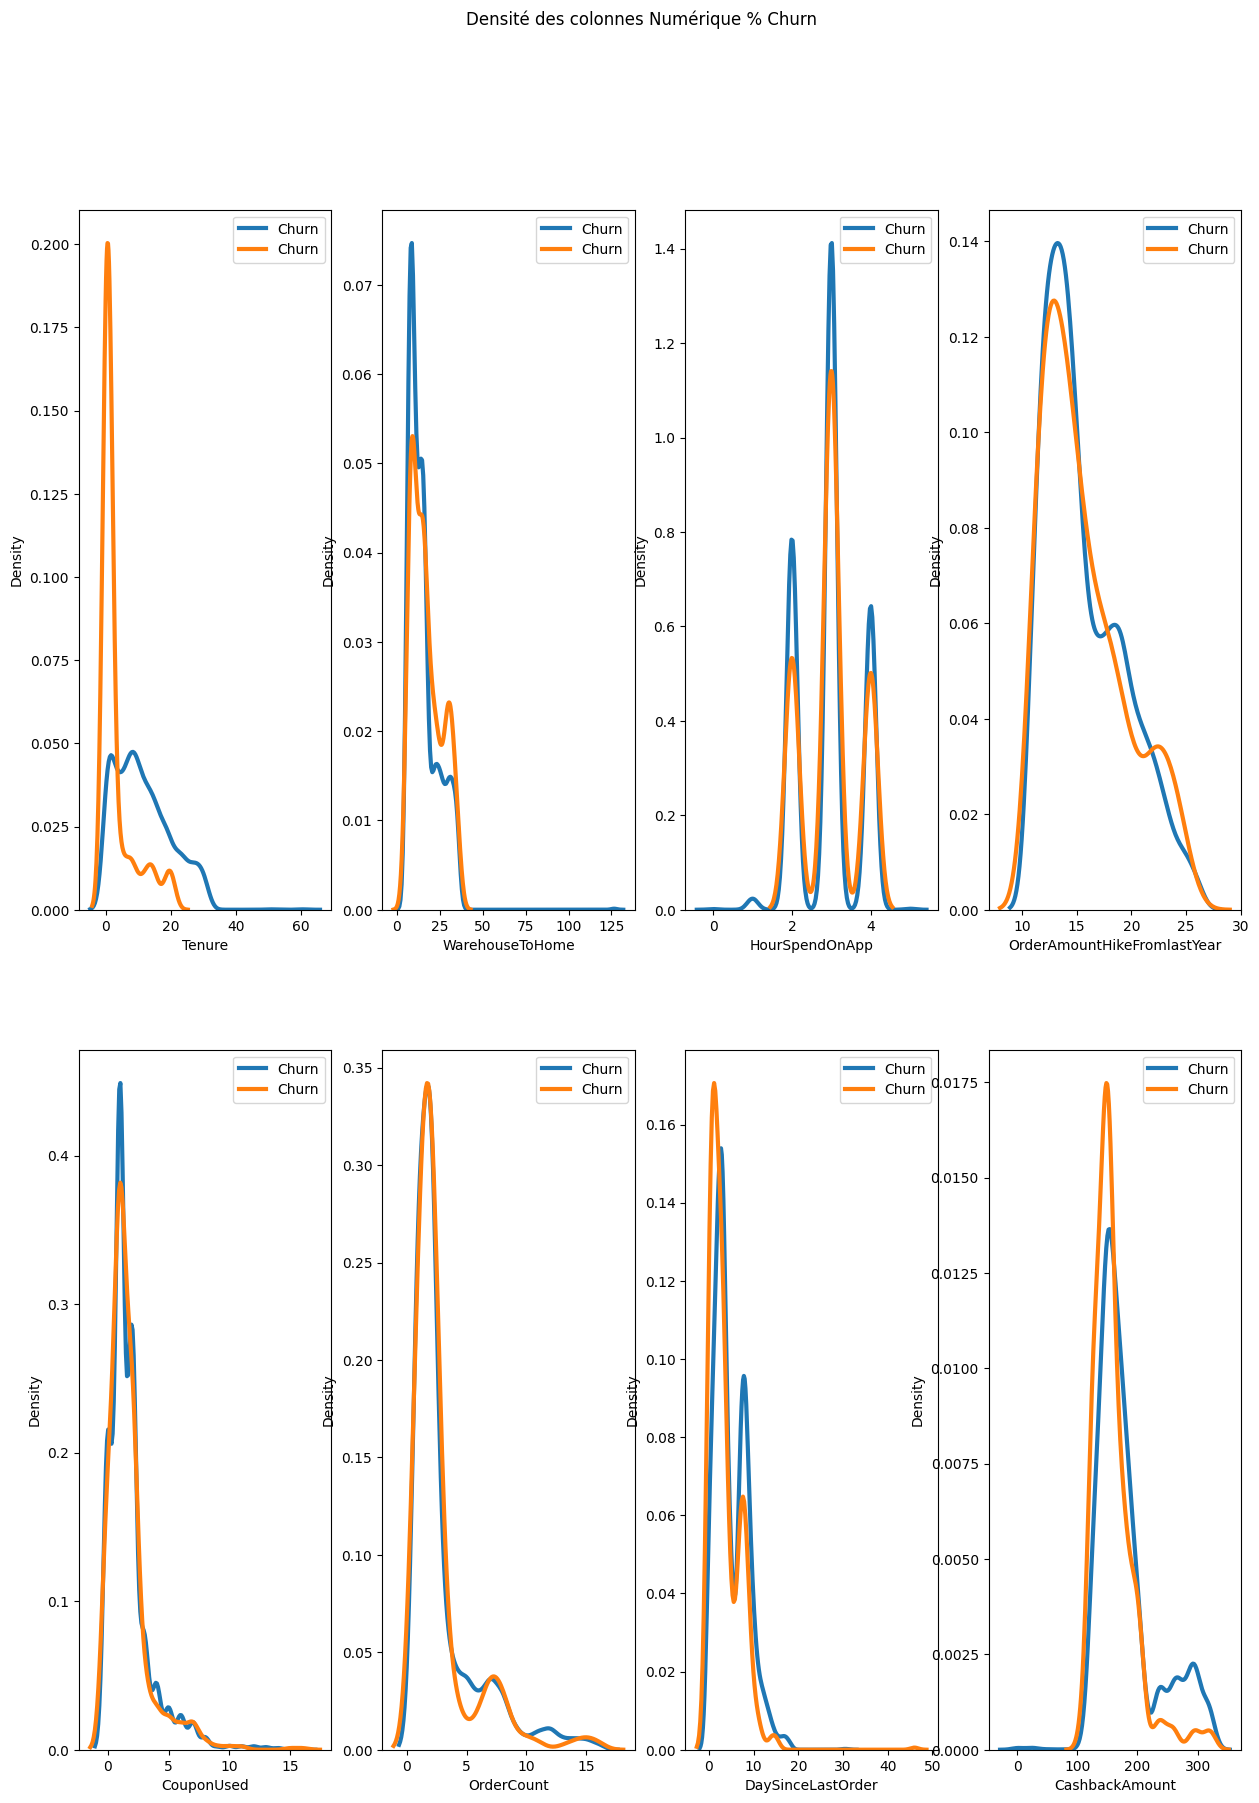

In [108]:
# l'impact  des colonnes numérique sur la colonne target 'Churn'
df_c = df[df['Churn']==0]
df_nc = df[df['Churn']==1]

fig, ax= plt.subplots(2,4 , figsize=(15,20))
fig.suptitle('Densité des colonnes Numérique % Churn')
ax = ax.flatten()

for i, c in enumerate(num_colonnes):
    sn.kdeplot(df_c[c], linewidth= 3,
             label = 'Churn',ax=ax[i])
    sn.kdeplot(df_nc[c], linewidth= 3,
             label = 'Churn',ax=ax[i])
    ax[i].legend(loc='upper right')

plt.show()

# Analyses des distributions des caractéristiques numériques

- **Tenure (Ancienneté)** : Les clients avec une ancienneté plus longue semblent moins susceptibles de résilier leur abonnement. Cela a du sens car une anciennté plus longue indique une satisfaction.


- **CityTier (Niveau de la ville)** : Le taux de résiliation semble similaire entre les différents niveaux de ville. Le niveau de la ville ne semble pas être prédictif de la résiliation.


- **WarehouseToHome (Distance entre l'entrepôt et la maison)** : Les distances plus courtes entre l'entrepôt et la maison ont un taux de résiliation plus faible. Des livraisons plus rapides peuvent améliorer la satisfaction.


- **HourSpendOnApp (Heures passées sur l'application)** : passer plus du temps sur l'application est corrélé à une résiliation plus faible. Le temps passé sur l'application est un bon indicateur.


- **NumberOfDeviceRegistered (Nombre de dispositifs enregistrés)** : plus le nombre de dispositifs enregistrés  est élevé plus la résiliation est faible. L'accès sur plusieurs dispositifs améliore la fidélité.


- **SatisfactionScore (Score de satisfaction)** : Des scores de satisfaction plus élevés sont fortement associés à une résiliation plus faible, comme prévu. Un élément clé.


- **NumberOfAddress (Nombre d'adresses)** :plus une personne a d'adresses enregistrées, moins elle est susceptible de résilier. Cela suggère que les clients avec plus d'adresses sont généralement plus fidèles.


- **Complaint (Réclamation)** : Plus de réclamations sont associées à une résiliation plus élevée, Les réclamations nuisent à la satisfaction.


- **OrderAmountHikeFromLastYear (Augmentation du montant de la commande depuis l'année dernière)** : Les clients ayant dépensé davantage l'année dernière sont moins susceptibles de résilier. Bon pour fidéliser les gros clients.


- **CouponUsed (Utilisation de coupons)** : L'utilisation de coupons est corrélée à une résiliation plus faible. Les coupons renforcent la fidélité.


- **OrderCount (Nombre de commandes)** : Un nombre élevé de commandes est associé à une résiliation plus faible. Une utilisation fréquente construit des habitudes.


- **DaySinceLastOrder (Jours depuis la dernière commande)** : Un laps de temps plus long depuis la dernière commande est corrélé à une résiliation plus élevée. La récence est un bon prédicteur.

/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:499: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:500: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:499: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:500: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:499: FutureWarning:

In a future version, the I

IndexError: ignored

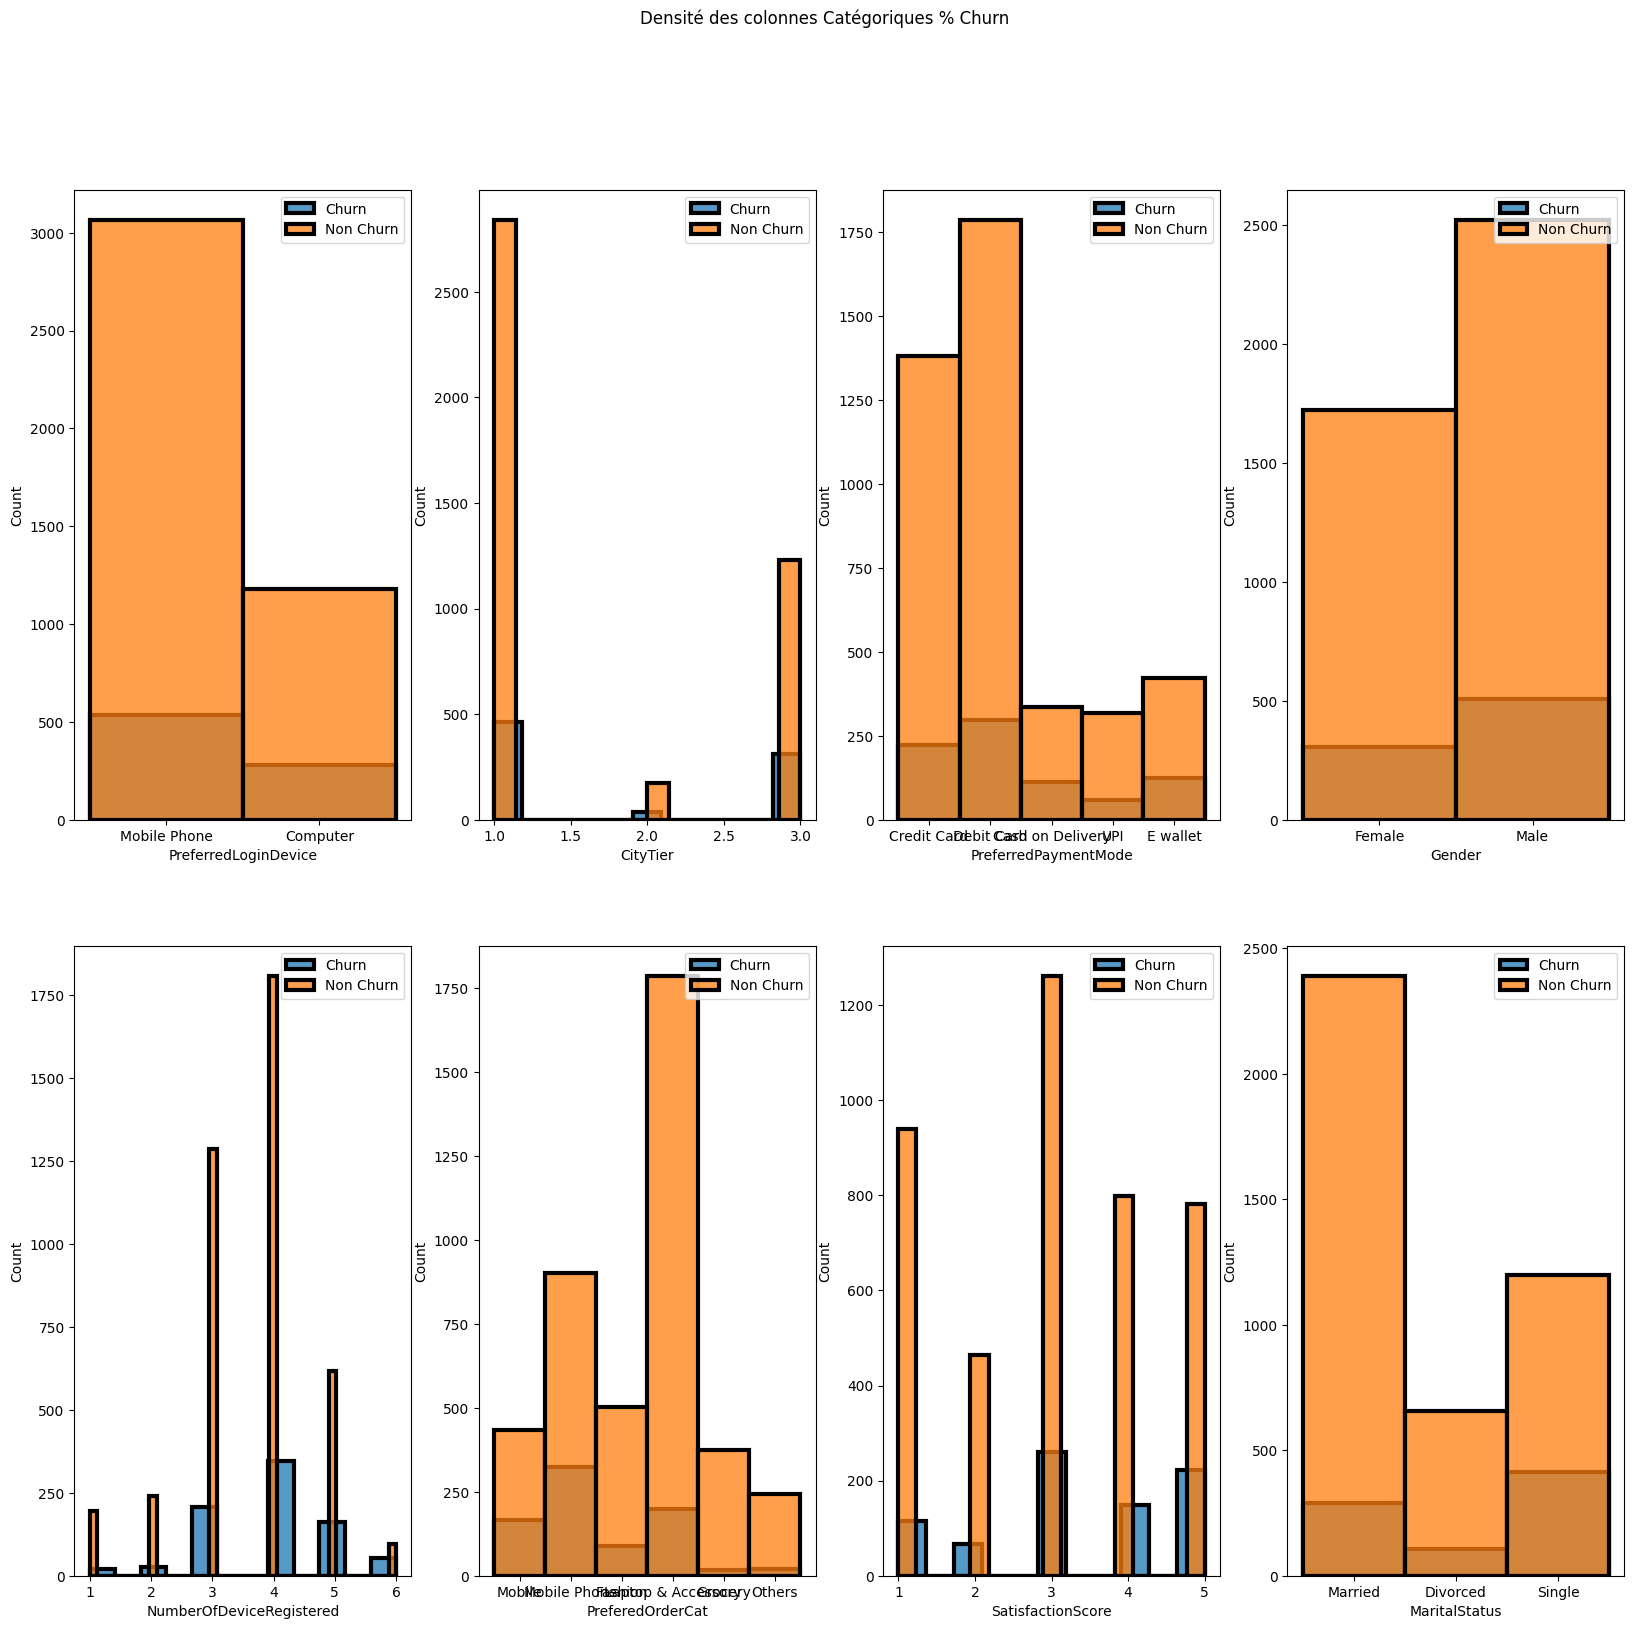

In [109]:
# l'impact  des colonnes catégoricals sur la colonne target 'Churn'
df_c = df[df['Churn']==1]
df_nc = df[df['Churn']==0]

fig, ax= plt.subplots(2,4 , figsize=(20,18))
fig.suptitle('Densité des colonnes Catégoriques % Churn')
ax = ax.flatten()

for i, c in enumerate(cat_colonnes):
    sn.histplot(df_c[c], linewidth= 3,
             label = 'Churn',ax=ax[i])
    sn.histplot(df_nc[c], linewidth= 3,
             label = 'Non Churn',ax=ax[i])
    ax[i].legend(loc='upper right')

plt.show()

**Commentaire sur les graphes ** a refaiiiireeeeee j'ai mélanger

- **PrefferedLoginDevice (outis de connexion préféré)** :


- **PrefferedPayementMode (mode de paiement préféré)**: Le taux de churn le plus élevé est pour les clients qui utilisent le paiement Credit card et Debit Card. .


- **Gender (sexe) **: Le taux de churn est plus élevé pour les hommes que pour les femmes. Cela peut être dû à des facteurs tels que les besoins et les attentes différents des hommes et des femmes. L'entreprise peut cibler ses efforts de marketing et de vente sur les besoins et les intérêts spécifiques des hommes


- **MaritalStatus (statut matrimonial)** : Le taux de churn est plus élevé pour les Mariés que pour les personnes Célibataires ou divorcées.


- **PrefferedOrder (catégorie de commande préférée)**: Le taux de churn est plus élevé pour les clients qui commandent des produits électroniques. Cela peut être dû au fait que les produits électroniques sont souvent plus chers et plus complexes que d'autres produits.l'entreprise peut fournir un meilleur support client et des garanties plus longues




Voir si ya une relation entre le genre et le churn

In [110]:
df['Gender'].value_counts()

Male      3032
Female    2027
Name: Gender, dtype: int64

In [111]:
df.groupby('Churn')['Gender'].value_counts()

Churn  Gender
0      Male      2523
       Female    1723
1      Male       509
       Female     304
Name: Gender, dtype: int64

In [112]:
femal_churn_rate = round(348/1898 * 100, 2)
mal_churn_rate = round(600/2784 *100,2)
print( 'Femal churn rate :', femal_churn_rate,'%')
print( 'Mal churn rate :', mal_churn_rate,'%')

Femal churn rate : 18.34 %
Mal churn rate : 21.55 %


<Axes: xlabel='Gender'>

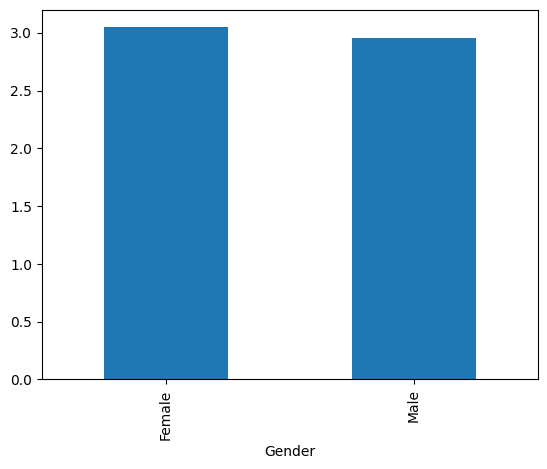

In [113]:
gender_orders = df.groupby('Gender')['OrderCount'].mean().plot(kind='bar')

gender_orders

In [114]:
import plotly.express as px

fig = px.pie(df, values='Churn', names='Gender')
fig.update_traces(marker=dict(colors=['pink ', 'baby blue']))
fig.update_layout(
  title='Churn % Genre',
  legend_title='Genre'
)

fig.show()

Comme nous pouvons le constater, les hommes ont plus de chances de résilier, avec 63,3 % de résiliations parmi les utilisateurs masculins de l'application. Peut-être que l'entreprise devrait envisager d'augmenter le nombre de produits susceptibles d'intéresser les hommes.

Nous allons examiner s'il existe d'autres facteurs expliquant pourquoi le segment le plus important de clients résiliés est constitué d'hommes.

# Quelle situation familliale à le taux le plus élevé de churn ?

In [115]:
df.groupby('Churn')['MaritalStatus'].value_counts()

Churn  MaritalStatus
0      Married          2391
       Single           1197
       Divorced          658
1      Single            415
       Married           290
       Divorced          108
Name: MaritalStatus, dtype: int64

 taux de churn des celibataire : 34.41 %
 taux de churn des mariés : 12.44 %
 taux de churn des divorcé : 16.69 %


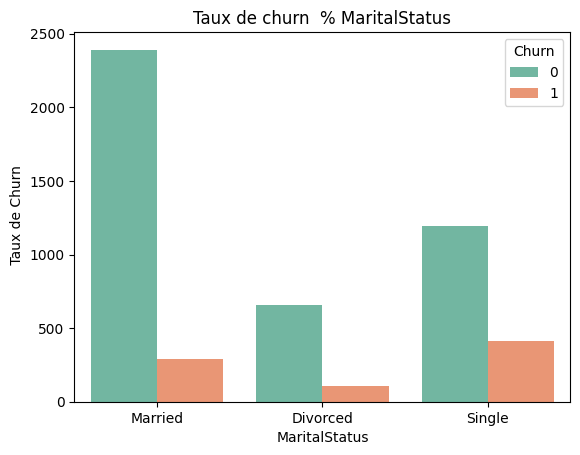

In [116]:
sn.countplot(x='MaritalStatus',hue='Churn',data=df,palette='Set2')
plt.title("Taux de churn  % MaritalStatus")
plt.ylabel(" Taux de Churn")
# 1 Churn , 0 Non Churn
print( ' taux de churn des celibataire :', round(435 / 1264 * 100, 2),'%')
print( ' taux de churn des mariés :', round(316 / 2540 * 100, 2), '%')
print( ' taux de churn des divorcé :', round(116 / 695 * 100,2),'%')

Les personnes mariées constituent le segment de clientèle le plus important de l'entreprise.  Les clients célibataires ont le taux de churn le plus élevé suivis des clients mariés ,L'entreprise devrait envisager de prendre soin des produits qui conviennent aux clients célibataires.

# Quel niveau de ville a le nombre de commande et l'anciennetée la plus élevé ?

In [117]:
df_grouped_tenure = df.groupby('CityTier')['Tenure'].agg(['mean', 'max'])
df_grouped_tenure

,mean,max
CityTier,,
1,10.416692,51.0
2,11.242857,31.0
3,9.260052,61.0


La ville de niveau 2 a le taux d'ancienneté le plus élevé, mais le taux d'ancienneté ne semble pas être un facteur déterminant.

In [118]:
df_grouped_OrderCount = df.groupby('CityTier')['OrderCount'].agg(['mean', 'max'])
df_grouped_OrderCount

,mean,max
CityTier,,
1,2.960358,16.0
2,2.752427,13.0
3,3.085208,16.0


La ville de niveau 3 a la moyenne de commandes la plus élevée, mais cela ne semble pas être un facteur déterminant dans la résiliation des clients

# Est-ce que les clients ayant un score de satisfaction élevé passent beaucoup de temps sur l'application ?

**Y a-t-il une corrélation entre le score de satisfaction et le temps passé sur l'application ?**

In [119]:
fig = px.histogram(df2, x="HourSpendOnApp", y="SatisfactionScore", orientation="h", color="Churn" ,
                   text_auto= True , title="<b>"+"Heures passées sur l'App Vs Score de satisfaction" ,
                   color_discrete_sequence = ['#BA1F33','#3A506B','#3E885B'])

fig.update_layout(hovermode='x',title_font_size=30)
fig.update_layout(
title_font_color="black",
template="plotly",
title_font_size=30,
hoverlabel_font_size=20,
title_x=0.5,
xaxis_title='HourSpendOnApp',
yaxis_title='SatisfactionScore',
)
fig.show()

Comme nous pouvons le constater, les personnes ayant un score de satisfaction plus faible passent moins de temps sur l'application que celles ayant un score de satisfaction de 5. Cependant, On ne peut pas affirmer  qu'il y ait une réelle relation entre le score de satisfaction et le temps passé par les personnes sur l'application

# Quel CityTier a le temps passé sur l'application le plus élevé ?

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:848: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:848: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:848: UserWarning:



`distplot` is a dep

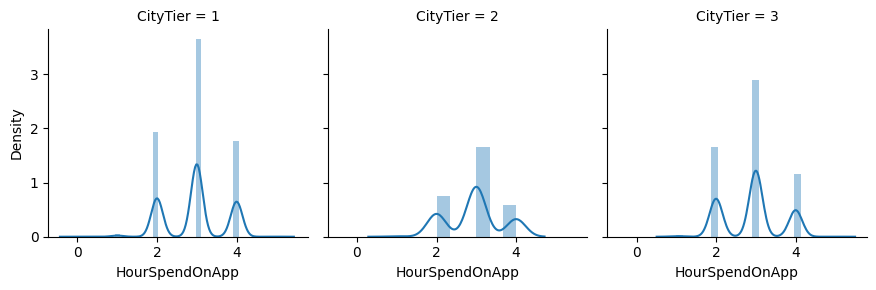

In [120]:
g = sn.FacetGrid(df, col='CityTier')
g.map(sn.distplot, 'HourSpendOnApp')

La ville de niveau 1 a passé le plus grand nombre d'heures sur l'application.

# Quelle est la relation entre les réclamations (Complain) et les jours depuis la dernière commande (DaySinceLastOrder) ?

In [121]:
df[['DaySinceLastOrder', 'Complain']].corr()

,DaySinceLastOrder,Complain
DaySinceLastOrder,1.000000,-0.051588
Complain,-0.051588,1.000000


Il y a une relation négative faible entre les réclamations et le nombre de jours depuis la dernière commande.

# Y a-t-il une relation entre le périphérique de connexion préféré (PreferredLoginDevice) et la résiliation (churn) ?

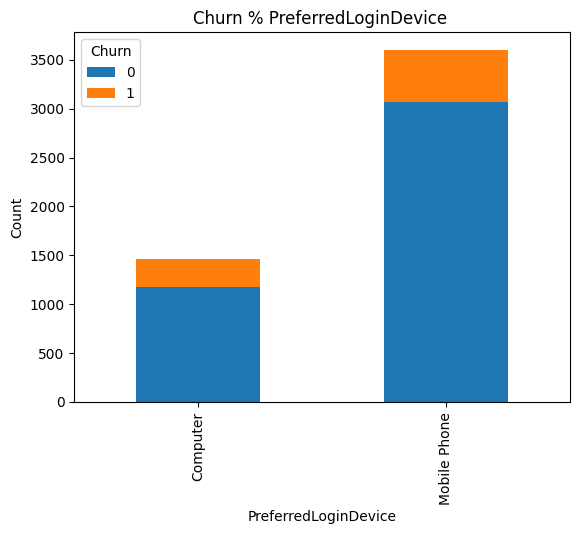

In [122]:
grouped_data = df.groupby(['PreferredLoginDevice', 'Churn']).size().unstack().plot(kind='bar', stacked=True)


plt.title('Churn % PreferredLoginDevice ')
plt.xlabel('PreferredLoginDevice')
plt.ylabel('Count')

plt.show()

mobile phone users are likely to churn may be this indicates a problem on the app user experience on the app mobile version

# Est-ce que les différents niveaux de ville ont des produits préférés différents?

In [123]:
import plotly.express as px
earth_palette = ["#A67C52", "#8F704D", "#B09B71", "#7E786E"]


fig=px.histogram(df,x="PreferedOrderCat",facet_col="CityTier",color="CityTier",
                 color_discrete_sequence=earth_palette,text_auto= True , title="<b>"+'CityTier % PreferedOrderCat')

# Personnalisation du grahe
fig.update_layout(hovermode='x',title_font_size=30)
fig.update_layout(
title_font_color="black",
template="plotly",
title_font_size=30,
hoverlabel_font_size=20,
title_x=0.5,
xaxis_title='PreferredPaymentMode',
yaxis_title='count',
)
fig.show()

# Quel est le mode de paiement préféré pour les différents niveaux de ville ?

In [124]:
df2['PreferredPaymentMode'].value_counts()

Debit Card          2083
Credit Card         1605
E wallet             546
Cash on Delivery     449
UPI                  376
Name: PreferredPaymentMode, dtype: int64

In [125]:
df2.groupby('CityTier')[['PreferredPaymentMode']].value_counts()

CityTier  PreferredPaymentMode
1         Debit Card              1511
          Credit Card             1256
          Cash on Delivery         318
          UPI                      222
2         UPI                      100
          Debit Card                56
          Credit Card               38
          Cash on Delivery          16
3         E wallet                 546
          Debit Card               516
          Credit Card              311
          Cash on Delivery         115
          UPI                       54
dtype: int64

In [51]:
import plotly.express as px

fig=px.histogram(df2,x="PreferredPaymentMode",facet_col="CityTier",color="CityTier",
                 color_discrete_sequence=['#BA1F33','#3A506B','#3E885B'],text_auto= True , title="<b>"+'CityTier Vs PaymentMethod')

# Personnnalisation du graphe
fig.update_layout(hovermode='x',title_font_size=30)
fig.update_layout(
title_font_color="black",
template="plotly",
title_font_size=30,
hoverlabel_font_size=20,
title_x=0.5,
xaxis_title='PreferredPaymentMode',
yaxis_title='count',
)
fig.show()

- Méthode de paiement préférée pour le niveau de ville '1' : DebitCard

- Méthode de paiement préférée pour le niveau de ville '2' : UPI

- Méthode de paiement préférée pour le niveau de ville '3' : E wallet

# Quel niveau de ville a le plus grand nombre de commandes (OrderCount) ?

In [127]:
df2.groupby('CityTier')[['OrderCount']].sum()

,OrderCount
CityTier,
1,9260.0
2,567.0
3,4526.0


In [128]:
fig = px.histogram(df2, x="OrderCount", y="CityTier", orientation="h", color="CityTier" ,
                   text_auto= True , title="<b>"+'CityTier Vs Somme des  OrderCount' ,
                   color_discrete_sequence = ['#BA1F33','#3A506B','#3E885B'])

fig.update_layout(hovermode='x',title_font_size=30)
fig.update_layout(
title_font_color="black",
template="plotly",
title_font_size=30,
hoverlabel_font_size=20,
title_x=0.5,
xaxis_title='La somme  des OrderCount',
yaxis_title='count',
)
fig.show()

Le niveau de ville '1' a le plus grand nombre de commandes avec 10 298 commandes.


# Est-ce que l'augmentation en pourcentage du nombre de commande depuis l'année dernière affecte le taux de résiliation (churn rate) ?

In [129]:
df2['OrderAmountHikeFromlastYear'].value_counts()

13.0    672
14.0    668
12.0    644
15.0    489
11.0    344
16.0    297
19.0    287
18.0    286
17.0    269
20.0    206
21.0    170
22.0    165
23.0    124
24.0     81
25.0     61
26.0     31
Name: OrderAmountHikeFromlastYear, dtype: int64

In [130]:
df2.groupby('OrderAmountHikeFromlastYear')['Churn'].count()

OrderAmountHikeFromlastYear
11.0    344
12.0    644
13.0    672
14.0    668
15.0    489
16.0    297
17.0    269
18.0    286
19.0    287
20.0    206
21.0    170
22.0    165
23.0    124
24.0     81
25.0     61
26.0     31
Name: Churn, dtype: int64

In [131]:
comp_ten = df2.groupby(["OrderAmountHikeFromlastYear", "Churn"]).size().reset_index(name="Count")

#  Creer des bubble
fig_bubble = px.scatter(comp_ten, x="OrderAmountHikeFromlastYear", y="Count", size="Count",
                        color="Churn", title="<b>"+'OrderAmountHikeFromlastYear VS Churn',
                        color_discrete_sequence=["#d62728", "#1f77b4"])

fig_bubble.update_layout(hovermode='x',title_font_size=30)
fig_bubble.update_layout(
title_font_color="black",
template="plotly",
title_font_size=30,
hoverlabel_font_size=20,
title_x=0.5,
xaxis_title='OrderAmountHikeFromlastYear',
yaxis_title='count',
)
fig_bubble.show()

Graphique montre que lorsque le pourcentage d'augmentation du nombre des commandes de l'année dernière augmente, le taux de résiliation diminue. Ainsi, OrderAmountHikeFromlastYear a un effet positif sur le taux de résiliation, nottament lorsque le pourcentage est compris entre 12% et 14%

# Quelle est la relation entre les réclamations (Complain) et le nombre de jours depuis la dernière commande (DaySinceLastOrder) pour les clients résiliés ?

In [132]:
df_c.groupby('Complain')[['DaySinceLastOrder']].sum()

,DaySinceLastOrder
Complain,
0,1293.0
1,1492.0


In [133]:
fig = px.histogram(df2, x="DaySinceLastOrder", color="Complain",text_auto= True ,
                   title="<b>DaySinceLastOrder Vs Complain" , color_discrete_sequence = ['#BA1F33','#3A506B'],
                   marginal="box") # or violin, rug)


fig.update_layout(hovermode='x',title_font_size=30)
fig.update_layout(
title_font_color="black",
template="plotly",
title_font_size=30,
hoverlabel_font_size=20,
title_x=0.5,
xaxis_title='DaySinceLastOrder',
yaxis_title='count',
)
fig.show()

# Quel est le nombre de commandes pour les clients qui passent beaucoup de temps sur l'application (High HourSpendOnApp) ?

In [134]:
df2['HourSpendOnApp'].agg(['min','max'])

min    0.0
max    5.0
Name: HourSpendOnApp, dtype: float64

In [135]:
bins = [0 , 1 , 3 , 6]
label = ['low' , 'medium' , 'high']
# Creer une nouvelle colonnes ' hourspendon app
df2['HourSpendOnApp_bins'] = pd.cut(df2['HourSpendOnApp'], bins=bins , labels = label)

In [ ]:
df2.groupby(['HourSpendOnApp_bins','OrderCount'])[['CustomerID']].count()

CustomerID
HourSpendOnApp_bins OrderCount            
low                 1.0                 16
                    2.0                  7
                    3.0                  1
                    4.0                  3
                    5.0                  0
                    6.0                  0
                    7.0                  2
                    8.0                  0
                    9.0                  0
                    10.0                 0
                    11.0                 1
                    12.0                 1
                    13.0                 0
                    14.0                 0
                    15.0                 0
                    16.0                 0
medium              1.0               1310
                    2.0               1135
                    3.0                248
                    4.0                144
                    5.0                115
                    6.0                 94
                    7.0                159
                    8.0                 87
                    9.0                 44
                    10.0                15
                    11.0                38
                    12.0                32
                    13.0                19
                    14.0                28
                    15.0                21
                    16.0                11
high                1.0                  0
                    2.0                689
                    3.0                 87
                    4.0                 28
                    5.0                 41
                    6.0                 26
                    7.0                 23
                    8.0                 61
                    9.0                  9
                    10.0                15
                    11.0                 4
                    12.0                13
                    13.0                 6
                    14.0                 0
                    15.0                 6
                    16.0                 6

In [136]:
sunbrust_gr = df2.loc[:,['HourSpendOnApp_bins','OrderCount']].dropna()

In [137]:
fig = px.sunburst(sunbrust_gr,path=['HourSpendOnApp_bins','OrderCount'],
                  title="<b>"+'HourSpendOnApp VS OrderCount',template="plotly" ,
                  color_discrete_sequence=["#78b4d5", "#d57f86" ,'#3E885B'])
fig.update_layout(hovermode='x',title_font_size=30)
fig.update_layout(
title_font_color="black",
template="plotly",
title_font_size=30,
hoverlabel_font_size=20,
title_x=0.5,
)
fig.update_traces(textinfo="label+percent parent")

fig.show()

Le segment de clients qui passe beaucoup de temps sur l'application a un nombre de commandes (OrderCount) égal à 2, avec un pourcentage de 67%.

# Y a-t-il une relation entre la catégorie de commande préférée et le taux de résiliation (churn rate) ?

In [138]:
df2.groupby(['PreferedOrderCat' , 'Gender'])[['CustomerID']].count()

CustomerID
PreferedOrderCat   Gender            
Fashion            Female         253
                   Male           338
Grocery            Female         191
                   Male           200
Laptop & Accessory Female         828
                   Male          1158
Mobile             Female         227
                   Male           373
Mobile Phone       Female         442
                   Male           785
Others             Female          86
                   Male           178

In [139]:
ordercat_churnrate = pd.DataFrame(df2.groupby('PreferedOrderCat')['Gender'].value_counts())
ordercat_churnrate = ordercat_churnrate.rename(columns={'Gender': 'Count'})
ordercat_churnrate = ordercat_churnrate.reset_index()


fig = px.histogram(ordercat_churnrate, x='PreferedOrderCat', y = ['PreferedOrderCat', 'Gender', 'Count'],
                   color='Gender', barmode='group',color_discrete_sequence=['rgba(58, 71, 80, 0.6)' ,'rgba(246, 78, 139, 1.0)'],
                   title="<b>"+'Prefered Category Vs Gender', barnorm = "percent",text_auto= True)
fig.update_layout(hovermode='x',title_font_size=30)
fig.update_layout(
title_font_color="black",
template="plotly",
title_font_size=30,
hoverlabel_font_size=20,
title_x=0.5,
xaxis_title='PreferedOrderCat',
yaxis_title='count',
)
fig.show()

- Top 2 des catégories préférées pour les hommes : [ Autres, Téléphone mobile ]
- Top 2 des catégories préférées pour les femmes : [ Épicerie, Mode ]

# Est-ce que les clients qui ont utilisé plus de coupons ont des taux de résiliation plus bas ?

In [140]:
df2.groupby(['CouponUsed' , 'Churn'])[['CustomerID']].count()

CustomerID
CouponUsed Churn            
0.0        0             730
           1             147
1.0        0            1564
           1             329
2.0        0             979
           1             206
3.0        0             259
           1              39
4.0        0             153
           1              23
5.0        0              97
           1              18
6.0        0              80
           1              14
7.0        0              64
           1              16
8.0        0              29
           1               5
9.0        0               7
           1               2
10.0       0               9
           1               2
11.0       0               8
           1               2
12.0       0               8
13.0       0               6
14.0       0               4
15.0       1               1
16.0       0               1
           1               1

In [141]:

coupoun_churnrate = pd.DataFrame(df2.groupby('CouponUsed')['Churn'].value_counts())
coupoun_churnrate = coupoun_churnrate.rename(columns={'Churn': 'Count'})
coupoun_churnrate = coupoun_churnrate.reset_index()


fig = px.bar(coupoun_churnrate, x='CouponUsed', y = ['CouponUsed', 'Churn', 'Count'] ,color='Churn',
             barmode='group',color_discrete_sequence=['rgba(58, 71, 80, 0.6)' ,'rgba(246, 78, 139, 1.0)'],
             title="<b>"+'CouponUsed Vs Churn Rate',text_auto= True)
fig.update_layout(hovermode='x',title_font_size=30)
fig.update_layout(
title_font_color="black",
template="plotly",
title_font_size=30,
hoverlabel_font_size=20,
title_x=0.5,
xaxis_title='CouponUsed',
yaxis_title='count',
)
fig.show()

Le graphique montre que le taux de résiliation diminue lorsque plus de coupons sont utilisés.

# Il y a une relation entre le montant du cashback (CashbackAmount) et le nombre de commandes qui ont lrésilié (churn) ?

In [142]:
df_c.groupby(['OrderCount','CashbackAmount'])[['Churn']].count()

Churn
OrderCount CashbackAmount       
1.0        110.09              2
           110.81              2
           110.91              2
           111.02              2
           111.18              2
...                          ...
15.0       127.43              2
           203.12              2
           295.45              2
16.0       152.43              2
           320.45              2

[394 rows x 1 columns]

In [143]:
fig = px.histogram(df2, x='CashbackAmount', y='OrderCount' ,color = 'Churn',
                   title="<b>"+'CashbackAmount Vs OrderCount  qui ont churn', color_discrete_sequence=["#d62728", "#1f77b4"])


fig.update_layout(hovermode='x',title_font_size=30)
fig.update_layout(
title_font_color="black",
template="plotly",
title_font_size=30,
hoverlabel_font_size=20,
title_x=0.5,
xaxis_title='CashbackAmount',
yaxis_title='OrderCount',
)
fig.show()

Les graphiques montrent qu'il n'y a pas de relation entre le montant du cashback et le nombre de commandes, mais il y a une relation positive entre le montant du cashback et le taux de résiliation.

# Est-ce que les clients qui se sont plaints sont plus susceptibles de résilier ?

In [144]:
df2.groupby('Complain')[['Churn']].count()

,Churn
Complain,
0,3609
1,1450


In [145]:
comp_churn = pd.DataFrame(df2.groupby('Complain')['Churn'].value_counts())
comp_churn = comp_churn.rename(columns={'Churn': 'Count'})
comp_churn = comp_churn.reset_index()
print(comp_churn)


   Complain  Churn  Count
0         0      0   3235
1         0      1    374
2         1      0   1011
3         1      1    439


In [146]:
comp_churn['Complain'] = comp_churn['Complain'].astype(str)
comp_churn['Churn'] = comp_churn['Churn'].astype(str)

comp_churn['Complain'].replace('0', 'No Complain', inplace=True)
comp_churn['Complain'].replace('1', 'Complain', inplace=True)
comp_churn['Churn'].replace('0', 'No Churn', inplace=True)
comp_churn['Churn'].replace('1', 'Churn', inplace=True)

print(comp_churn)

      Complain     Churn  Count
0  No Complain  No Churn   3235
1  No Complain     Churn    374
2     Complain  No Churn   1011
3     Complain     Churn    439


In [147]:
fig = px.treemap(comp_churn, path=['Complain', 'Churn'],
                 values='Count',  color_discrete_sequence=["#2F4B26", '#FF0000'],
                 title="<b>" + 'Complain Vs Churn')

# Mise à jour des traces et du style du treemap
fig.update_traces(textinfo="label+percent parent+value", root_color="lightgrey")
fig.update_layout(margin=dict(t=70, l=25, r=25, b=25))

# Personnaliser le style du treemap
fig.update_layout(hovermode='x', title_font_size=30)
fig.update_layout(
    title_font_color="black",
    template="plotly",
    title_font_size=30,
    hoverlabel_font_size=20,
    title_x=0.5,
)

fig.show()

L'absence de réclamation n'affecte pas la résiliation, comme le montre le graphique. Les clients qui ont formulé des plaintes représentent 68%, mais ne résilient pas.

Conclusions de l'analyse exploratoire des données (EDA) :

- Il n'y a pas une grande différence entre les hommes et les femmes en ce qui concerne la moyenne des commandes.
- Les hommes ont plus de chances de résilier, avec 63,3 % de résiliations chez les hommes depuis l'application. Il se pourrait que l'entreprise doive envisager d'augmenter les produits qui suscitent l'intérêt des hommes, et nous allons examiner s'il existe d'autres facteurs qui expliquent pourquoi le segment le plus important de clients résiliés est composé d'hommes.
- Les personnes mariées représentent le segment de clients le plus important dans l'entreprise. Il pourrait être judicieux pour l'entreprise de prendre en compte les produits adaptés aux clients célibataires et mariés, car les célibataires sont les plus susceptibles de résilier depuis l'application.
- Le CityTier 2 a le taux de permanence le plus élevé, mais le taux de permanence ne semble pas être un facteur déterminant.
- Le CityTier 3 a la moyenne d'ordres la plus élevée, mais cela ne semble pas être un facteur déterminant dans la résiliation des clients.
- Les personnes ayant un score de satisfaction plus faible passent moins de temps sur l'application que celles ayant un score de satisfaction de 5, mais je ne pense pas qu'il y ait de relation entre le score de satisfaction et le temps passé sur l'application.
- Le CityTier 1 a le plus grand nombre d'heures passées sur l'application.
- Il y a une corrélation négative entre CityTier et NumberOfAddress. Les CityTiers plus élevés sont associés à une moyenne de NumberOfAddress plus basse et à une distribution plus concentrée. Les clients des grandes villes (CityTier 1) ont en moyenne plus d'adresses que ceux des villes plus petites des niveaux inférieurs.
- Il y a une relation faible et négative entre les plaintes et le nombre de jours depuis la dernière commande.
- Les utilisateurs de téléphones mobiles sont plus susceptibles de résilier, ce qui peut indiquer un problème avec l'expérience utilisateur sur la version mobile de l'application.
- Les ordinateurs portables et accessoires, ainsi que les téléphones mobiles, sont les catégories préférées pour tous les niveaux de ville.
- Méthode de paiement préférée pour CityTier '1' ==> Carte de débit, CityTier '2' ==> UPI, CityTier '3' ==> Portefeuille électronique. Il y a une forte préférence pour la carte de débit dans tous les niveaux.
- CityTier '1' a le plus grand nombre de commandes avec 10 298 commandes.
- CityTier '3' a la plus grande moyenne d'ordres, ce qui signifie que CityTier '3' a un nombre moins élevé de clients, mais ceux-ci passent de nombreuses commandes, qualifiés de "richTier".
- Lorsque le pourcentage de commandes de l'année dernière augmente, le taux de résiliation diminue. Ainsi, OrderAmountHikeFromlastYear a un effet positif sur le taux de résiliation, et nous devrions nous concentrer lorsque le client a un pourcentage de 12% à 15%.
- Les clients qui n'ont pas formulé de plainte ont un plus grand nombre de jours depuis la dernière commande. Cependant, il n'y a qu'un seul client dans cette catégorie, ce qui en fait une donnée aberrante. Si nous le supprimons, les clients sans plainte ont un nombre de jours depuis la dernière commande inférieur.
- Le segment de clients qui passe beaucoup de temps sur l'application a un OrderCount de 2 avec un pourcentage de 67%.
- Les deux catégories préférées des hommes sont [Autres, Téléphone portable], et les deux catégories préférées des femmes sont [Épicerie, Mode].
- La résiliation diminue lorsque l'utilisation de coupons augmente.
- La satisfactionScore n'affecte pas le nombre de commandes.
- Il n'y a pas de relation entre le montant du cashback et le nombre de commandes, mais il y a une relation positive entre le montant du cashback et le taux de résiliation.
- Les plaintes n'affectent pas la résiliation. Les clients qui formulent des plaintes représentent 68%, mais ne résilient pas.

# Data preprocessing

# **1- Valeurs manquantes**

In [24]:
#pourcentage des vall manquantes
round((df.isnull().sum()*100 / df.shape[0]),2)

CustomerID                     0.00
Churn                          0.00
Tenure                         0.00
PreferredLoginDevice           0.00
CityTier                       0.00
WarehouseToHome                4.96
PreferredPaymentMode           0.00
Gender                         0.00
HourSpendOnApp                 5.04
NumberOfDeviceRegistered       0.00
PreferedOrderCat               0.00
SatisfactionScore              0.00
MaritalStatus                  0.00
NumberOfAddress                0.00
Complain                       0.00
OrderAmountHikeFromlastYear    5.24
CouponUsed                     5.06
OrderCount                     5.10
DaySinceLastOrder              0.00
CashbackAmount                 0.00
dtype: float64

le taux des valeurs manquantes est inferieur à 6% on peut donc les supprimer

<Axes: xlabel='Tenure', ylabel='Density'>

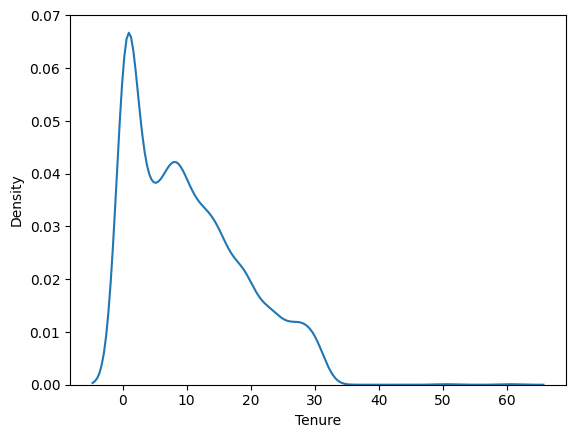

In [25]:
sn.kdeplot(df , x='Tenure')

In [26]:
# remplacer les val manquantes de la colonne WarehouseToHome ( pourcentage de 4.96%) par les val les plus frequentes
from sklearn.impute import SimpleImputer
s_imp = SimpleImputer(missing_values=np.nan , strategy = 'most_frequent')
df['WarehouseToHome'] = s_imp.fit_transform(pd.DataFrame(df['WarehouseToHome']))

In [151]:
df['WarehouseToHome'].isnull().sum()

0

In [27]:
# Remplacer les val manquantes de la colonne  HourSpendOnApp par des valeurs random de la mm colonnes ( non nan)
nvl_list = df['HourSpendOnApp'].dropna()
df['HourSpendOnApp'] = df['HourSpendOnApp'].fillna(pd.Series(np.random.choice(nvl_list , size = len(df['HourSpendOnApp'].index))))

In [28]:
df['HourSpendOnApp'].isnull().sum()

0

In [29]:
# remplacer les valeurs manquantes par la valeurs precedentes ( non manauanqtes )
df['OrderAmountHikeFromlastYear'] = df['OrderAmountHikeFromlastYear'].fillna(method = 'ffill')

In [30]:
df['OrderAmountHikeFromlastYear'].isnull().sum()

0

In [31]:
# traiter avec les k voisin plus proches knn pour CouponUsed et OrderCount
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)
df['CouponUsed']=imputer.fit_transform(df[['CouponUsed']])
df['OrderCount']=imputer.fit_transform(df[['OrderCount']])

In [32]:
df['CouponUsed'].isnull().sum()

0

In [33]:
df['OrderCount'].isnull().sum()

0

# Supprimer les colonnes qui ne sont pas importantes :

In [34]:
print(len(df))

5059


In [35]:
# Vérifier les valeurs distinctes de chaque colonnes ( les colonnes dont la val distinct  = len(df) ne sont pas importante)
for col in colonnes:
  print('pour la colonne: ', col)
  print(len(list(df[col].unique())))
  print('-------------------------------------------')

pour la colonne:  CustomerID
5059
-------------------------------------------
pour la colonne:  Churn
2
-------------------------------------------
pour la colonne:  Tenure
36
-------------------------------------------
pour la colonne:  PreferredLoginDevice
2
-------------------------------------------
pour la colonne:  CityTier
3
-------------------------------------------
pour la colonne:  WarehouseToHome
34
-------------------------------------------
pour la colonne:  PreferredPaymentMode
5
-------------------------------------------
pour la colonne:  Gender
2
-------------------------------------------
pour la colonne:  HourSpendOnApp
6
-------------------------------------------
pour la colonne:  NumberOfDeviceRegistered
6
-------------------------------------------
pour la colonne:  PreferedOrderCat
6
-------------------------------------------
pour la colonne:  SatisfactionScore
5
-------------------------------------------
pour la colonne:  MaritalStatus
3
--------------------

In [36]:
# supprimer la colonne ID qui n'apporte aucune info ( val distinct = len(df))
df.drop('CustomerID' , axis = 1 , inplace = True)

# **2- Encodage :**

In [37]:
# colonnes categoricales
data_cat = df[df.select_dtypes(exclude=np.number).columns]
data_cat

,PreferredLoginDevice,PreferredPaymentMode,Gender,PreferedOrderCat,MaritalStatus
0,Mobile Phone,Debit Card,Female,Grocery,Married
1,Mobile Phone,Debit Card,Male,Laptop & Accessory,Divorced
2,Mobile Phone,Debit Card,Male,Laptop & Accessory,Divorced
3,Mobile Phone,Debit Card,Female,Grocery,Married
4,Mobile Phone,Debit Card,Female,Mobile Phone,Married
...,...,...,...,...,...
5054,Mobile Phone,Debit Card,Female,Mobile Phone,Single
5055,Mobile Phone,UPI,Female,Mobile Phone,Married
5056,Mobile Phone,Credit Card,Male,Mobile Phone,Married
5057,Mobile Phone,UPI,Female,Mobile Phone,Single


In [38]:
colonnes = df.columns

In [39]:
le = LabelEncoder()
# Encoder les cat_cols
for col in colonnes:
  if df[col].dtype == 'object':
    df[col] = le.fit_transform(df[col])

df.head(4)

,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,0,60.0,1,3,27.0,2,0,3.0,3,1,1,1,5,1,13.0,1.750989,1.0,0.0,278.75
1,0,50.0,1,1,6.0,2,1,3.0,1,2,3,0,1,0,24.0,1.000000,2.0,8.0,149.00
2,0,51.0,1,1,7.0,2,1,4.0,2,2,3,0,2,0,25.0,2.000000,3.0,9.0,174.00
3,0,61.0,1,3,28.0,2,0,4.0,4,1,1,1,6,1,25.0,1.000000,2.0,1.0,303.75


In [40]:
# verifier
df[df.select_dtypes(exclude=np.number).columns]


""
0
1
2
3
4
...
5054
5055
5056
5057


In [41]:
# verifier
for col in data_cat.columns:
  data_cat[col]= le.fit_transform(data_cat[col])
data_cat.head(4)

<ipython-input-41-aca761fd3abd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cat[col]= le.fit_transform(data_cat[col])
<ipython-input-41-aca761fd3abd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cat[col]= le.fit_transform(data_cat[col])
<ipython-input-41-aca761fd3abd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

,PreferredLoginDevice,PreferredPaymentMode,Gender,PreferedOrderCat,MaritalStatus
0,1,2,0,1,1
1,1,2,1,2,0
2,1,2,1,2,0
3,1,2,0,1,1


# **3- traiter les outlier:**

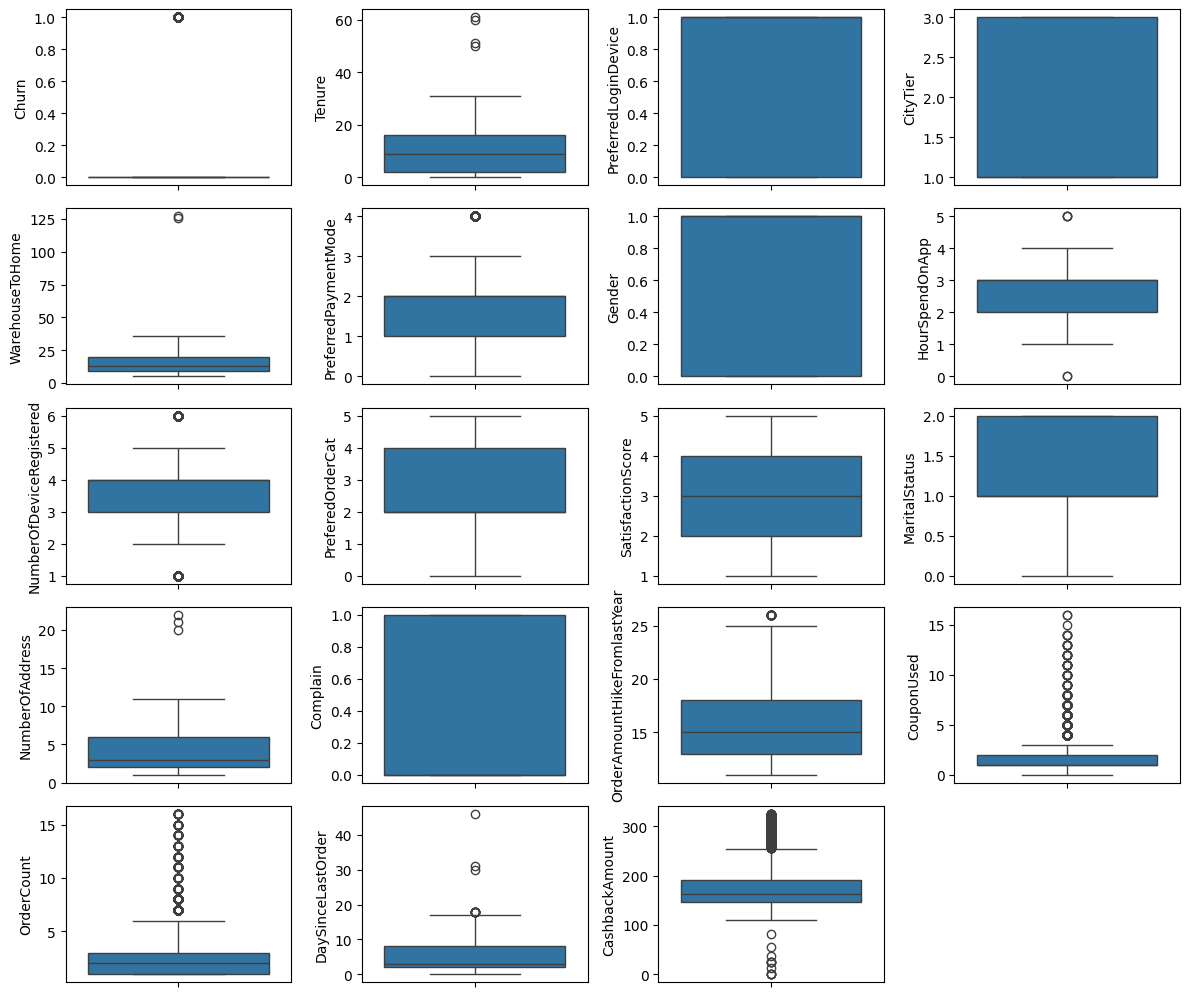

In [42]:
fig = plt.figure(figsize=(12,18))
for i in range(len(df.columns)):
    fig.add_subplot(9,4,i+1)
    sn.boxplot(y=df.iloc[:,i])

plt.tight_layout()
plt.show()

In [43]:
def traiter_outliers(df , column_name):
  Q1 = df[column_name].quantile(0.25)
  Q3 = df[column_name].quantile(0.75)
  IQR = Q3 - Q1
  # définir les  bornes d'intervalle
  Upper = Q3 + IQR * 1.5
  lower = Q1 - IQR * 1.5
  #  faire un filtre
  new_df = df[ (df[column_name] > lower) & (df[column_name] < Upper) ]

  return new_df

In [44]:
cols_outliers = ['Tenure' , 'WarehouseToHome' , 'NumberOfAddress' ,
                 'DaySinceLastOrder' , 'HourSpendOnApp' , 'NumberOfDeviceRegistered']

for col in cols_outliers:
    df = traiter_outliers(df , col)

print(len(df))

4650


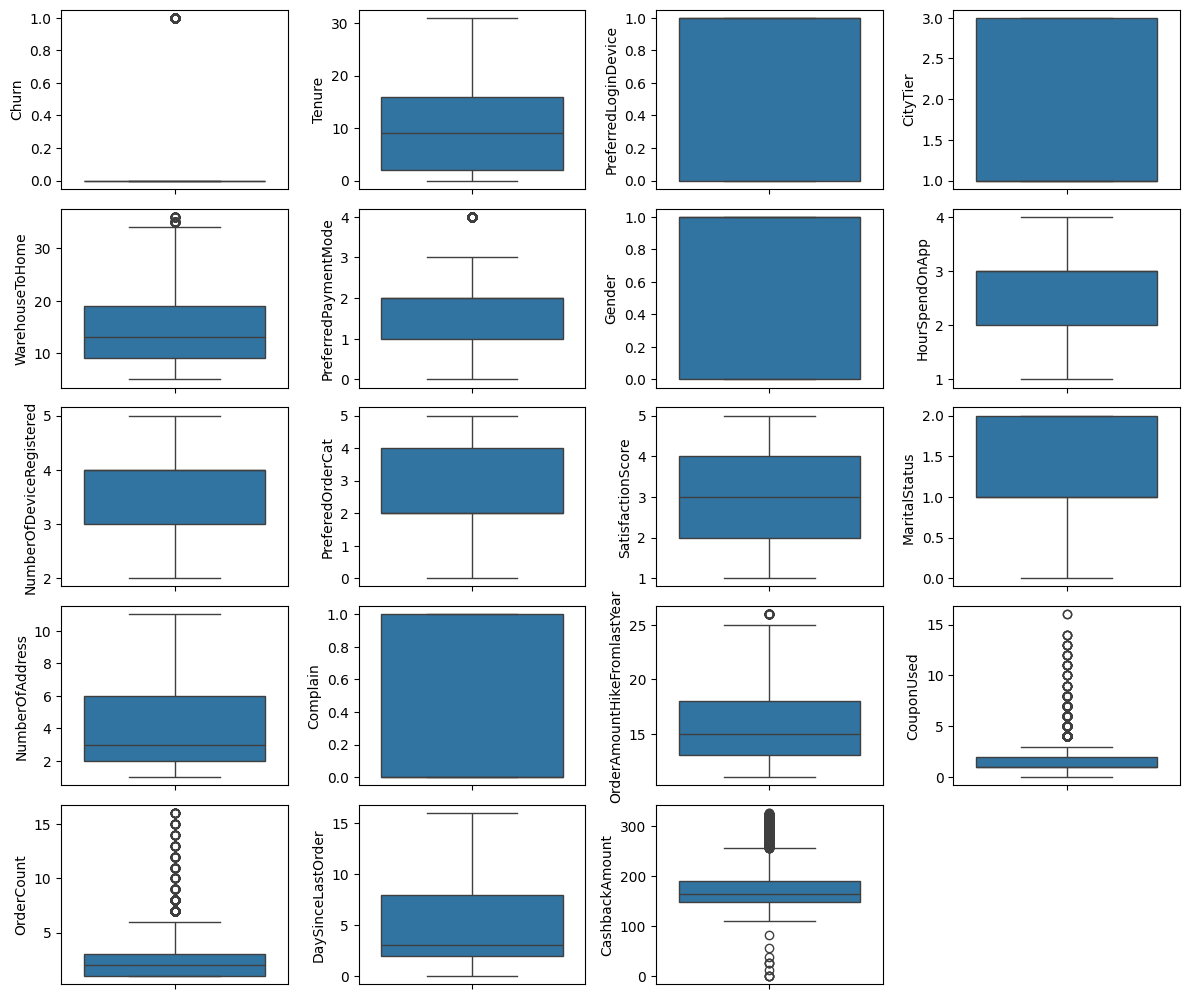

In [45]:
#Vérifier
fig = plt.figure(figsize=(12,18))
for i in range(len(df.columns)):
    fig.add_subplot(9,4,i+1)
    sn.boxplot(y=df.iloc[:,i])

plt.tight_layout()
plt.show()

In [46]:
# correlation
corr_matrix = df.corr()
corr_matrix

,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
Churn,1.000000,-0.353828,-0.042617,0.061011,0.054396,-0.015897,0.034387,0.005562,0.073122,0.119247,0.098106,0.129591,0.027237,0.247578,0.012016,-0.018719,-0.035629,-0.160306,-0.165447
Tenure,-0.353828,1.000000,0.033081,-0.067405,-0.014867,-0.003554,-0.052877,-0.013588,-0.021103,-0.156443,-0.004968,-0.108121,0.259658,-0.033018,0.004068,0.137338,0.189508,0.190723,0.488227
PreferredLoginDevice,-0.042617,0.033081,1.000000,0.009001,-0.021086,0.007821,-0.019733,0.014971,-0.011117,0.011751,0.041160,-0.024568,0.039090,0.002088,0.008698,-0.004611,-0.018626,-0.030447,0.050123
CityTier,0.061011,-0.067405,0.009001,1.000000,0.018273,0.248857,-0.026749,-0.036733,-0.013280,-0.195400,-0.002895,0.004387,-0.045316,-0.008974,-0.028484,-0.001397,0.018901,0.005514,0.015804
WarehouseToHome,0.054396,-0.014867,-0.021086,0.018273,1.000000,0.010353,-0.019099,0.086112,0.023201,-0.100498,0.008688,-0.027508,0.002144,0.018689,0.036605,0.011168,0.009294,0.038047,0.025944
PreferredPaymentMode,-0.015897,-0.003554,0.007821,0.248857,0.010353,1.000000,0.015267,-0.020582,0.007554,-0.051059,-0.020301,-0.019467,-0.006618,0.021163,0.002730,-0.018871,-0.055038,-0.019942,0.026147
Gender,0.034387,-0.052877,-0.019733,-0.026749,-0.019099,0.015267,1.000000,-0.007847,-0.024799,0.074709,-0.043032,-0.014577,-0.037122,-0.032378,-0.014882,-0.016236,-0.010546,-0.018877,-0.019952
HourSpendOnApp,0.005562,-0.013588,0.014971,-0.036733,0.086112,-0.020582,-0.007847,1.000000,0.258810,0.140512,0.034122,-0.044827,0.126182,0.000257,0.097820,0.169336,0.088351,0.066048,0.071893
NumberOfDeviceRegistered,0.073122,-0.021103,-0.011117,-0.013280,0.023201,0.007554,-0.024799,0.258810,1.000000,0.089583,-0.009868,0.030952,0.055880,-0.003234,0.059901,0.113679,0.060816,0.002744,0.078738
PreferedOrderCat,0.119247,-0.156443,0.011751,-0.195400,-0.100498,-0.051059,0.074709,0.140512,0.089583,1.000000,-0.012522,0.041862,-0.048024,-0.003645,0.044958,-0.056527,-0.076378,-0.187277,-0.184603


<Axes: >

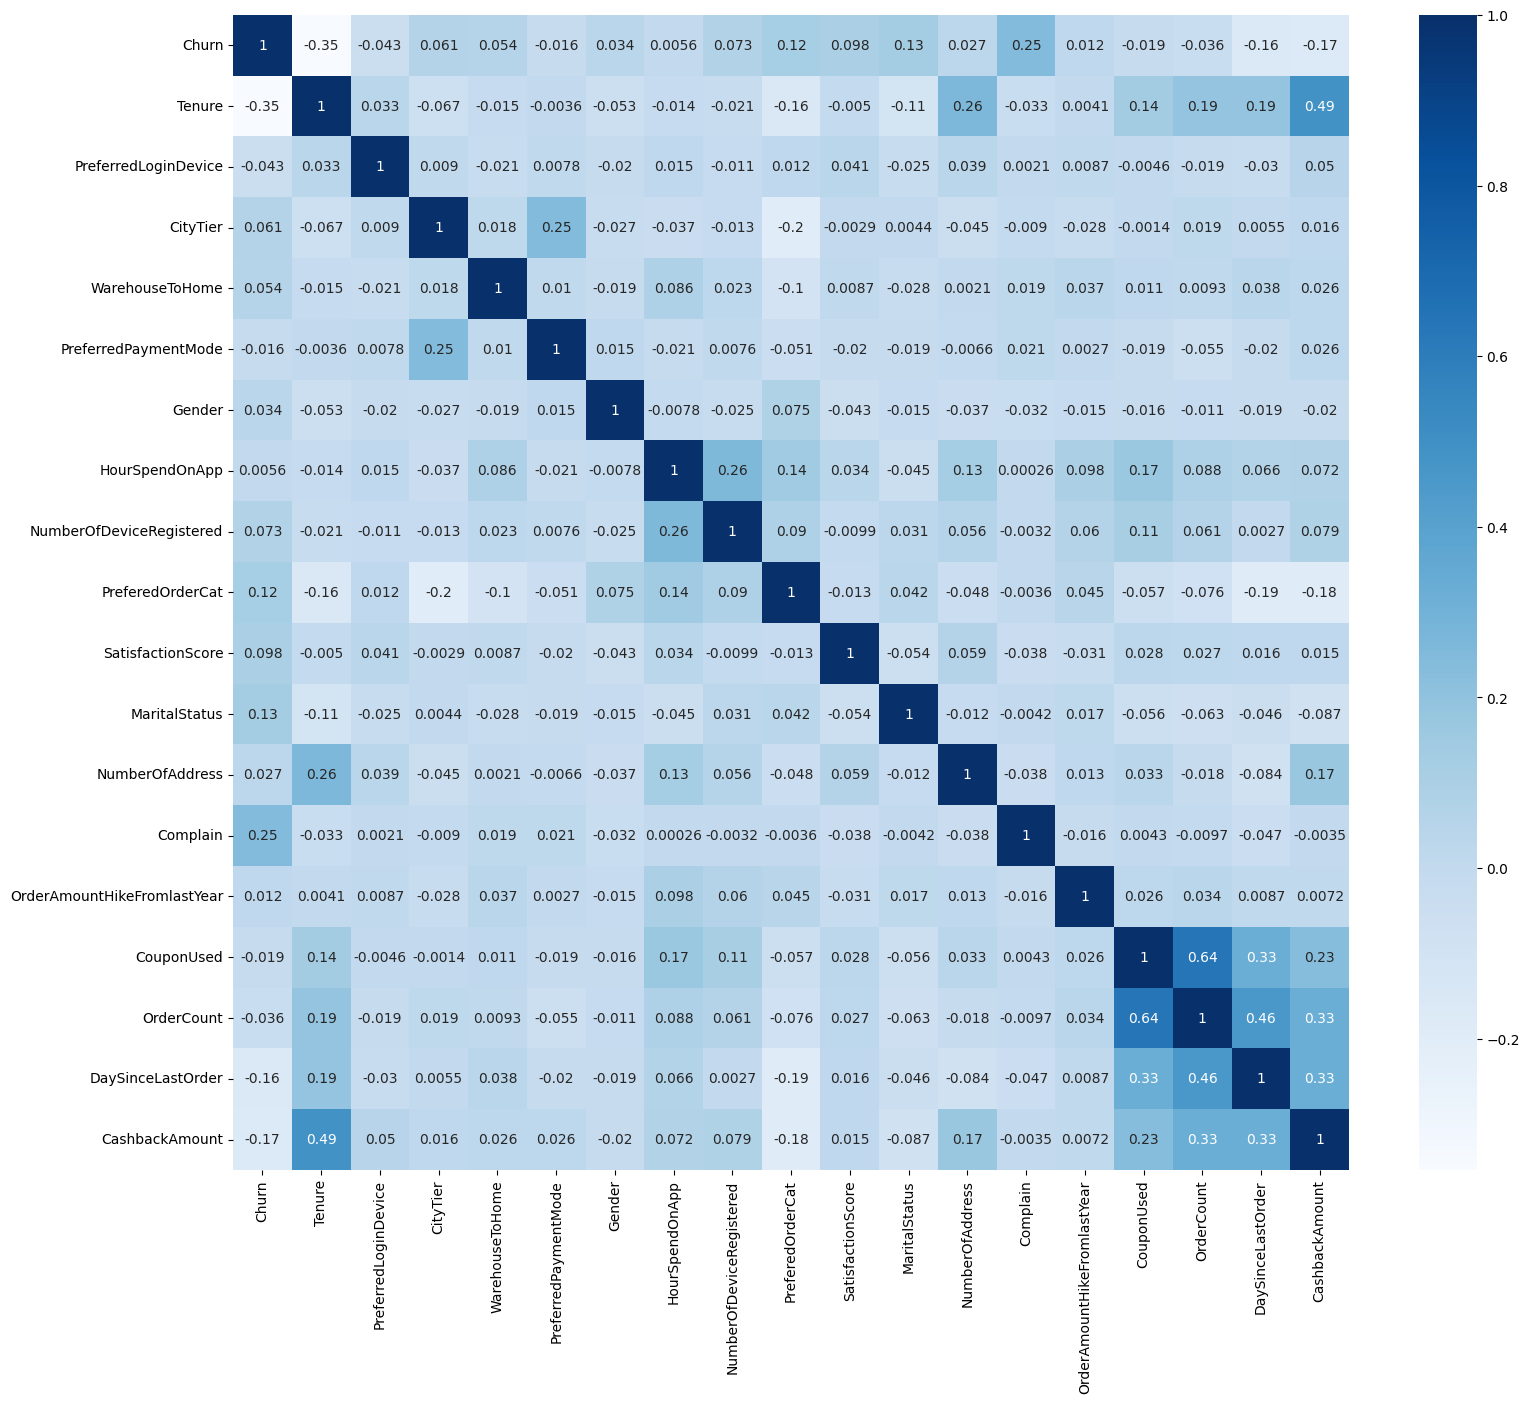

In [47]:
plt.figure(figsize = (18,15))
sn.heatmap(df.corr() , annot = True , cmap = 'Blues')

In [48]:
# trier les clonnes en fonction des correlations
corr_trie = corr_matrix['Churn'].sort_values(ascending = False)
corr_trie

Churn                          1.000000
Complain                       0.247578
MaritalStatus                  0.129591
PreferedOrderCat               0.119247
SatisfactionScore              0.098106
NumberOfDeviceRegistered       0.073122
CityTier                       0.061011
WarehouseToHome                0.054396
Gender                         0.034387
NumberOfAddress                0.027237
OrderAmountHikeFromlastYear    0.012016
HourSpendOnApp                 0.005562
PreferredPaymentMode          -0.015897
CouponUsed                    -0.018719
OrderCount                    -0.035629
PreferredLoginDevice          -0.042617
DaySinceLastOrder             -0.160306
CashbackAmount                -0.165447
Tenure                        -0.353828
Name: Churn, dtype: float64

<ipython-input-49-6dc8a217ae4d>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sn.barplot(x = corr_trie , y = corr_trie.index , palette = 'coolwarm')


Text(0.5, 1.0, 'Relation entre les var descriptives et le target')

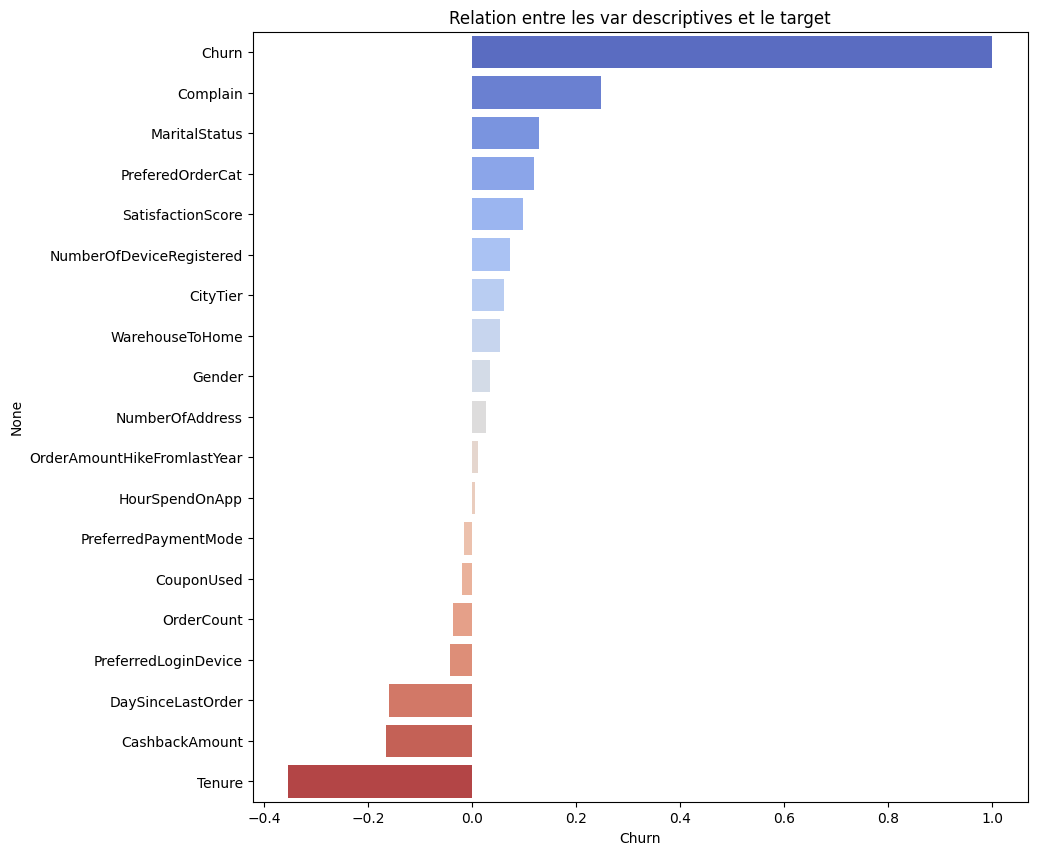

In [49]:
plt.figure(figsize = (10,10))
sn.barplot(x = corr_trie , y = corr_trie.index , palette = 'coolwarm')
plt.title('Relation entre les var descriptives et le target')

# **Traiter le désiquélibre des données :**

In [52]:
fig = px.histogram(df2, x="Churn", color="Churn" ,text_auto= True ,
                   title="<b>"+"verifier l'equilibre des deux classes" , color_discrete_sequence = ['#BA1F33','#3A506B'])


fig.update_layout(hovermode='x',title_font_size=30)
fig.update_layout(
title_font_color="black",
template="plotly",
title_font_size=30,
hoverlabel_font_size=20,
title_x=0.5,
xaxis_title='Churn',
yaxis_title='count',
)
fig.show()

In [53]:
X = df.drop('Churn' , axis = 1)
Y = df['Churn']


In [54]:
X = X.astype(float)
Y = Y.astype(int)

In [55]:
# surrechantillonage de la classe minoritaire
from imblearn.combine import SMOTETomek
smt = SMOTETomek(random_state=42)
x_smoke , y_smoke = smt.fit_resample(X , Y)

In [56]:
x_smoke.shape, y_smoke.shape

((7826, 18), (7826,))

# **Data Split**

In [57]:
x_train , x_test , y_train , y_test = train_test_split(x_smoke , y_smoke , test_size = 0.30 , random_state = 42)

# **Normalisation**

In [58]:
from sklearn.preprocessing import MinMaxScaler , StandardScaler , RobustScaler

MN = MinMaxScaler()
x_train_scaled = MN.fit_transform(x_train)
x_test_scaled = MN.fit_transform(x_test)

# **Construction des modèle:**

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

In [60]:
logisreg_clf = LogisticRegression()
svm_clf = SVC()
dt_clf = DecisionTreeClassifier()
rf_clf = RandomForestClassifier()
XGB_clf = XGBClassifier()
ada_clf = AdaBoostClassifier()

In [61]:
clf_list = [logisreg_clf, svm_clf, dt_clf, rf_clf, XGB_clf, ada_clf]
clf_name_list = ['Logistic Regression', 'Support Vector Machine',
                 'Decision Tree', 'Random Forest', 'XGBClassifier' , 'AdaBoostClassifier']

for clf in clf_list:
    clf.fit(x_train_scaled,y_train)

In [73]:
train_acc_list = []
test_acc_list = []
f1_score_list = []
model_results=[]

for clf,nom in zip(clf_list,clf_name_list):
    y_pred_train = clf.predict(x_train_scaled)
    y_pred_test = clf.predict(x_test_scaled)
    print(f'Avec le model: {nom}')
    print(f'Trainning Score: {clf.score(x_train_scaled, y_train)}')
    print(f'Test Score: {clf.score(x_test_scaled, y_test)}')
    print(f'Acc Train: {accuracy_score(y_train, y_pred_train)}')
    print(f'Acc Test: {accuracy_score(y_test, y_pred_test)}')


    f1 = f1_score(y_test, y_pred_test)
    print(f'F1 Score : {f1}')
    f1_score_list.append(f1)
    # Matrice de confusion
    conf_matrix = confusion_matrix(y_test, y_pred_test)
    print(f'Confusion Matrix :')
    print(conf_matrix)

    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    train_acc_list.append((nom, train_accuracy))
    test_acc_list.append((nom, test_accuracy))
    model_results.append((nom, train_accuracy, test_accuracy, f1))


    print('                                                   ' )
    print('******************************************************')
    print('                                                    ' )

Avec le model: Logistic Regression
Trainning Score: 0.8263964950711938
Test Score: 0.8185689948892675
Acc Train: 0.8263964950711938
Acc Test: 0.8185689948892675
F1 Score : 0.8269699431356622
Confusion Matrix :
[[ 904  244]
 [ 182 1018]]
                                                   
******************************************************
                                                    
Avec le model: Support Vector Machine
Trainning Score: 0.9477911646586346
Test Score: 0.9280238500851788
Acc Train: 0.9477911646586346
Acc Test: 0.9280238500851788
F1 Score : 0.9305384299219072
Confusion Matrix :
[[1047  101]
 [  68 1132]]
                                                   
******************************************************
                                                    
Avec le model: Decision Tree
Trainning Score: 1.0
Test Score: 0.9505962521294719
Acc Train: 1.0
Acc Test: 0.9505962521294719
F1 Score : 0.9524590163934427
Confusion Matrix :
[[1070   78]
 [  38 1162]]
  

In [74]:
df_resultat = pd.DataFrame(model_results, columns=['Modèle', 'Précision sur le train', 'Précision sur le test', 'F1 Score'])

print(df_resultat)

                   Modèle  Précision sur le train  Précision sur le test  \
0     Logistic Regression                0.826396               0.818569   
1  Support Vector Machine                0.947791               0.928024   
2           Decision Tree                1.000000               0.950596   
3           Random Forest                1.000000               0.983816   
4           XGBClassifier                1.000000               0.978279   
5      AdaBoostClassifier                0.923330               0.916951   

   F1 Score  
0  0.826970  
1  0.930538  
2  0.952459  
3  0.984258  
4  0.978917  
5  0.919654  


In [1]:
df_resultat.head(6)

NameError: ignored

In [ ]:
model.save('64x3-CNN.model')

In [ ]:



def predict_churn(data):

  MN = MinMaxScaler()
  data_scaled = MN.transform(data)
  # Prédictions avec le modèle Random Forest celui qui a montrer les meilleur resultat
  prediction = rf_clf.predict(data_scaled)

return prediction

def main():
st.title("Prédiction de Churn")

bash

# Zone de saisie pour les données
st.header("Entrez les données pour la prédiction:")
tenure = st.number_input("Tenure:")
city_tier = st.number_input("CityTier:")
warehouse_to_home = st.number_input("WarehouseToHome:")


# Bouton pour effectuer la prédiction
if st.button("Prédire"):
    # Créez un DataFrame avec les données pour effectuer la prédiction
    input_data = pd.DataFrame({
        'Tenure': [tenure],
        'CityTier': [city_tier],
        'WarehouseToHome': [warehouse_to_home],
        # Ajoutez d'autres colonnes avec les valeurs entrées
    })

    # Obtenez la prédiction
    prediction = predict_churn(input_data)

    # Affichez la prédiction
    st.subheader("Résultat de la prédiction:")
    st.write("Churn prédit:", prediction)

if name == "main":
main()

In [ ]:
df.columns

In [ ]:
colonnes